# Introduction
 
In this notebook I will outline the approach used to apply the data from the experiments to the theory. The ultimate aim is to generate predictions as to how interactions between species within a community affect the temperature sensitivity of its emergent respiartory carbon flux. First I will outline the theory associated with the model fiting, what models I will use and the information that will be required to infer parameters. Then I will apply these methods to the data from the experiments, derive parameter estimates. Finally I will use these to predict the emergent carbon flux and its temperature sensitvity, comparing these to the real data.

# The Theory

As discussed in the previous notebook the carbon flux of any multispecies ecosystem is given by:

$$
R_{eco} = \sum_{i = 1}^{N} R_{i} \ N_{i}
$$

where $R_{eco}$ is the total respiratory carbon flux of an ecosystem and $R_{i}$ and $N_{i}$ are the cell-specific respiration and abundance of species $i$ respectively. We can further decompose the abundance component here by considering that the growth rate of any species population is given by some function of it's intrinsic growth rate $r_i$ and abundance of all species in the system via interactions, $\vec{N}$ with a set of parameters $\vec{\theta}$ determining the nature of these interactions:

$$
\frac{dN_i}{dt} = f(r_i,\vec{N},\vec{\theta})
$$

of which the integral gives the abundance at any time $t$:

$$
\int \frac{dN_i}{dt} dt = \int f(r_i,\vec{N},\vec{\theta}) dt = N_i(t,r_i,\vec{N},\vec{\theta})
$$

Thus we can see that total flux in a system will depend based on the nature of the interaction between species ($\vec{\theta}$) as abundance dynamics change over time:

$$
R_{eco} = \sum_{i = 1}^{S} R_{i} \ C(t,r_i,\vec{N},\vec{\theta})
$$

## Temperature

As per ecological metabolic theory, we expect that temperature will affect metabolic processes occuring within indivduals due to the fundamental biochemical basis for these processes. In the case of the model above temperature enters at three points. Firstly it directly affects the rate of respiration, $R_i(T)$. Secondly it indirectly affects the abundance component  intrinsic rate of growth $r_i(T)$. And lastly via the nature of interactions between species $\vec{\theta}(T)$. Over time these last two will cause changes in abundance of species (i.e. higher growth rates will result in more abundance or stronger competitve interactions will result in lower abundances), changing the total respiration in the system. Thus we can rewrite the equation above as:

$$
R_{eco} = \sum_{i = 1}^{S} R_{i}(T) \ N(t,r_i(T),\vec{N},\vec{\theta}(T))
$$

clearly indicating the temperature dependence of total ecosystem respiration. Though the equation above is not analytically solveable (due to the complexities that arrise when considering multiple interacting components) we can use numerical simulations to see how the abundance dynamics change over time and how temperature affect this process (see the previous notebook).

## A model for ecosystem dynamics

The equation above represents the general case for an ecosystem and encompasses all models that describe ecosystem dynamics, depending on the form of the function $f(.)$. In order to derive any predictions for abundance dynamics we must make explicit how species populations grow and interact. The simplest model to use is the generalised lotka-volterra (GLV) which has the form:

$$
\frac{dN_i}{dt} = f_i(.) = N_i(r_i(T) + \sum_{j = 1}^{S} a_{ij}(T) N_j)
$$

where $a_{ij}$ is the interaction coefficent describing the effect of species $j$ upon species $i$

We can write total ecosystem respiration including the solution to this growth equation:

$$
R_{eco} = \sum_{i = 1}^{S} R_{i}(T) \int N_i(r_i(T) + \sum_{i = 1}^{S} a_{ij}(T) N_j) \ dt
$$

Thus we need three parameters to work out R_{eco}:
* $R_{i}(T)$ - Respiration for each species
* $r_i(T)$ - The intrinsic growth rate for each species
* $a_{ij}(T)$ - The interaction terms for each species pair 

Bellow I discuss how each of these parameters can be infered from the experimental data.

### Respiration - $R_i(T)$

Respiration and its temperature dependence are relatively easy to parameterise given the experimetnal data. We have good measures of respiration for each species across a range of temperatures. We can fit sharpe-scholefield models to these to characterise them. 

### growth rates - $r_i(T)$
Parameterising the growth rates is also relatively straightforward depending on the data. Though growth rate was not measured explictly over different temperatures (i.e. with logistic curve fits) we have measurements of abundance (through flow cytometry), before and after the respiration measurements were taken, with the time interval recorded. Thus we can assume exponential growth and use the following formula to estimate growth rate:

$$
r_i = \frac{log(N_i(t)) - log( N_i(0))}{t}
$$

It is worth noting that this approximation only works if the bacteria are in or near the exponential phase over the time interval. If the interval is longer than he exponential phase then we will systematically underestimate growth rates as shown in the figure bellow using simulated data:

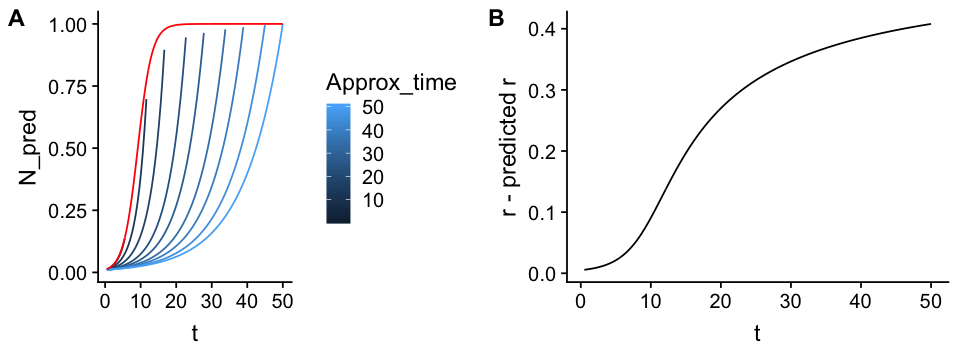

In [114]:
suppressWarnings(library(tidyverse))
library(cowplot)

r = 0.5; N0 = 0.01; K = 1
N_sim <- data.frame(t = seq(0,50,length.out = 100), r,N0, K) %>%
    mutate(N = K / (1 + ((K-N0)/(N0))*exp(-t*r))) %>%
    mutate(r_pred = (log(N)-log(N0)) / t)

#generate exponential approximates
t_app <- round(seq(1,50,length.out = 10))
r_app <- (log(K / (1 + ((K-N0)/(N0))*exp(-t_app*r))) - log(N0)) / t_app
N_app <- matrix(NA,100,10)
colnames(N_app) <- t_app

for(i in 1:10){
    N_tmp <- 0.01 * exp(r_app[i] * N_sim$t[N_sim$t <= t_app[i]])
    N_app[1:length(N_tmp),i] <- N_tmp
}

N_sim <- cbind(N_sim,as.data.frame(N_app)) %>%
    gather("Approx_time","N_pred",7:16) %>%
    mutate(Approx_time = as.numeric(Approx_time)) %>%
    filter(!is.na(N_pred),!is.na(r_pred))

p1 <- N_sim %>% 
    ggplot(aes(x = t))+
        geom_line(aes(y = N_pred, group = Approx_time, colour = Approx_time))+
        geom_line(aes(y = N),colour = "red")

p2 <- N_sim %>%
    ggplot(aes(x=t,y=r - r_pred))+
        geom_line()+
        ylab("r - predicted r")

options(repr.plot.width = 8, repr.plot.height = 3)
plot_grid(p1,p2,labels = c("A","B"))

A) Here the "real" growth curve in red is generated using the logistic growth equation with a fixed growth rate and carrying capacity. I then take the biomass across a range of time intervals and estimate $r$ using the equation above. Each of these lines represents a different time point chosen and the exponential growth curve that this generates. We can see that as the time point moves away from the exponential phase the curve becomes less and less like the logistic growth curve we are trying to approximate.B) This is showm more explictly in this plot which shows the difference in the estimated growth rate and the real growth rate (i.e. the error in our growth rate calculation) as a function of time with the difference increasing as we move away from the exponential phase. 

### Interactions

The last step is to get an estimate of the interactions between species, $a_{ij}$ . To do this we use the fact that we have (in theory) estimates of the growth of both individual species, $r_i$ and the growth rate when they are grown in pairs $r_{i_j}$ (i.e. the growth of species $i$ when grown with species $j$ including the effect of interactions). 

Taking the two species case we can write the change in abundance of each population as:

$$
    \frac{dN_{i}}{dt} = N_i (r_i - a_{ii} N_i - a_{ij} N_j) \quad \frac{dN_{j}}{dt} = N_j (r_j - a_{jj} N_j - a_{ji} N_i)
$$

Then rearanging for the $a_{ij}$ and $a_{ji}$ terms we get:

$$
    a_{ij} = \frac{r_i - a_{ii} N_i - \frac{1}{N_i}\frac{dN_{i}}{dt}}{N_j} 
    \quad
    a_{ji} = \frac{r_j - a_{jj} N_j - \frac{1}{N_j}\frac{dN_{j}}{dt}}{N_i}
$$

So the interaction term can be obtained by taking the difference between species growth rate and the growth of the species in isolation, divided by the con-specific density. These values all need to be evaluated at a single point in time which for convienience I take to be $t=0$. 

whilst we know the growth parameters of the species in isolation from the previous experiment we still need to estimate the growth of each species in the presence of the other. As in the experiments species are seeded at low densities and mesurements taken in exponential phase we can approximate the growth rate as:

$$
\left. \frac{dN_{i}}{dt} \right \lvert_{t = 0} \approx r_{i_j} N_i
\quad
\left. \frac{dN_{j}}{dt} \right \lvert_{t = 0} \approx r_{j_i} N_j
$$

where $r_{i_j}$ is the growth rate of species $i$ in the presence of species $j$

thus we can write the interaction terms as:

$$
    a_{ij} = \frac{ r_i - r_{i_j} - a_{ii} N_i}{N_j} 
    \quad
    a_{ji} = \frac{ r_j - r_{j_i} - a_{jj} N_j}{N_i} 
$$

#### The symmetric case

If it is not possible to establish the growth rates of each species indivdually when grown together one can make the simplifying assumption that interactions are symmetrical (i.e. $a_{ij} = a_{ji}$) and that the intraspecific interactions are weak in the exponential phase ($a_{ii} \approx 0$). This allows the interaction term to be written as a single value for the pairwise case $a$. To do this we need only the emergent growth rate of the pairwise combination $r_{pair}$:

$$
a = \frac{2 r_{pair} - r_i - r_j }{N_{pair}}
$$

# Parameterisation

In this section I will obtain the parameters using the methods detailed above. 

In [115]:
Cyt_all <- read_csv("../data/Francisca/FlowCytometry_All.csv",
                   col_types = cols(ID = col_character(),
                                    AbuT1 = col_double(),
                                    AbuT0 = col_double(),
                                    u = col_double(),
                                    AT = col_double(),
                                    Replicate = col_double(),
                                    Id = col_character(),
                                    Level = col_character(),
                                    Treatment = col_character(),
                                    Media = col_character(),
                                    Temperature = col_double()
                                    ))

## Respiration - $R$

Species level respiration is the easiest parameter to get from the data as we have experiments that aimed to determine their TPCs directly.

In [116]:
library(rTPC)
library(nls.multstart)
library(broom)

#read in data
OTU_R <- read_csv("../data/Francisca/respirationandODData//RespDataLinear_OTUs_evNev.csv",
                  col_types = cols(Sps = col_character(),
                                   T = col_double(),
                                   Replicate = col_double(),
                                   Resp = col_double(),
                                   Treatment = col_character()
                                ))

OTU_R <- OTU_R %>%
mutate(OTU = as.numeric(str_replace(Sps,"R_","")),
       Resp = - Resp,
       Temp = T + 273.15,
       Treatment = str_replace(Treatment,regex("^evo"),"Evo")) %>%
       filter(Resp > 0)

#remove 20 & Evolved outliers (should check if this is ok...)
ind <- which((OTU_R$Treatment == "Evolved") & (OTU_R$OTU == 20) & (OTU_R$Resp > 1.1))
OTU_R <- OTU_R[-ind,]

#remove some other outliers, this isnt good but looking at the fits makes sense...
ind <- which((OTU_R$Treatment == "Evolved") & (OTU_R$OTU == 23) & (OTU_R$Temp > 301) & (OTU_R$Temp < 305))
OTU_R <- OTU_R[-ind,]

#normalise to per-cell rate
OTU_R <- Cyt_all %>%
    filter(Level == "Species", Id != 9) %>%
    select(AbuT0,Replicate,Id,Treatment,Temperature)%>%
    mutate(Temp = Temperature + 273.15, OTU = as.numeric(Id) ,Treatment=recode(Treatment,"Denovo"="Nonevolved"))%>%
    select(OTU,Treatment,Temp,Replicate,N0 = AbuT0) %>%
    left_join(OTU_R) %>%
    mutate(Resp = Resp / N0) %>%
    filter(!is.na(Resp))

ind <- which(OTU_R$OTU == 23 & OTU_R$Treatment == "Nonevolved" & OTU_R$Temp > 310 & OTU_R$Resp > 1e-6)
OTU_R <- OTU_R[-ind,]


Joining, by = c("OTU", "Treatment", "Temp", "Replicate")


In [182]:
#Fit ss-models
OTU_R_fits <- OTU_R %>%
group_by(OTU,Treatment) %>%
  nest() %>%
  mutate(., ss = map(data, ~nls_multstart(Resp ~ sharpeschoolhigh_1981(temp_k = Temp, r_tref, e, eh, th, tref = 20),
                       data = .x,
                       iter = 500,
                       start_lower = get_start_vals(.x$Temp, .x$Resp, model_name = 'sharpeschoolhigh_1981') - 10,
                       start_upper = get_start_vals(.x$Temp, .x$Resp, model_name = 'sharpeschoolhigh_1981') + 10,
                       lower = c(r_tref = -Inf, e = 0, eh = 0, th = -Inf),
                       upper = c(r_tref = Inf, e = 3, eh = Inf, th = Inf),
                       supp_errors = 'Y')))

paste("Models fitted: ",length(OTU_R_fits$ss) , "/", 10)

[1] "Models fitted:  10 / 10"

In [183]:
#predicting fits
newdata <- tibble(Temp = seq(min(OTU_R$Temp), max(OTU_R$Temp), length.out = 100))

OTU_R_pred <- gather(OTU_R_fits, 'model', 'output', ncol(OTU_R_fits)) %>%
  unnest(., output %>% map(augment, newdata = newdata))


OTU_R_E <- gather(OTU_R_fits, 'model', 'output', ncol(OTU_R_fits)) %>%
  mutate(., est = map(output, est_params)) %>%
  select(., -c(data, output)) %>%
  unnest(est)

Warning message in min(newdata_extrap[, param_ind], na.rm = TRUE):
“no non-missing arguments to min; returning Inf”Warning message in numericDeriv(form[[3L]], names(ind), env):
“NaNs produced”Warning message in numericDeriv(form[[3L]], names(ind), env):
“NaNs produced”Warning message in numericDeriv(form[[3L]], names(ind), env):
“NaNs produced”

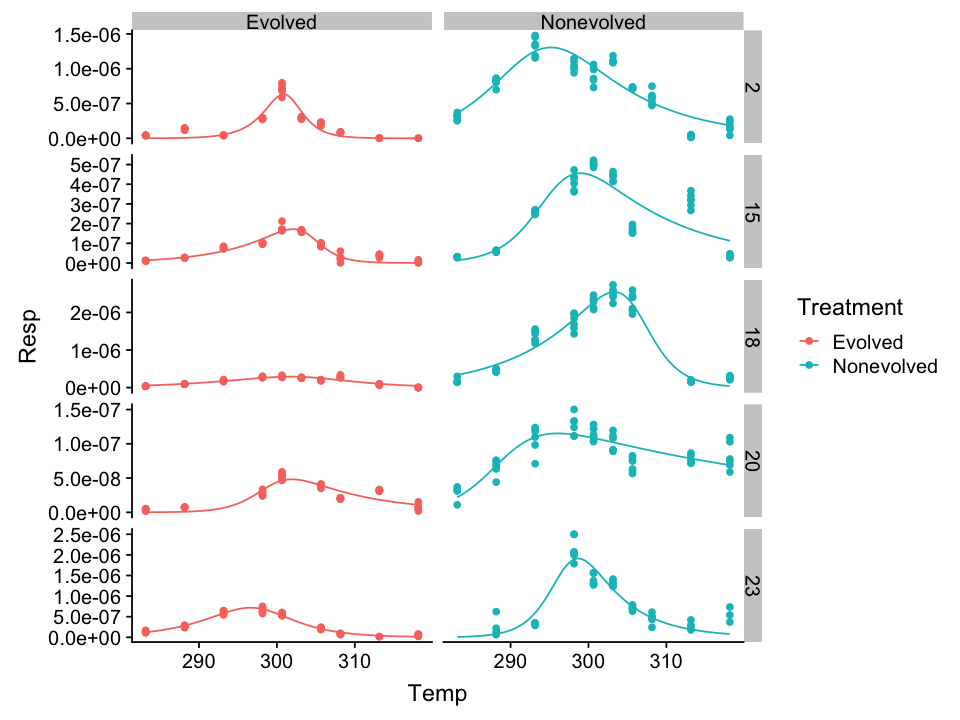

In [184]:
options(repr.plot.width = 8, repr.plot.height = 6)

OTU_R %>%
    ggplot(aes(x=Temp,y = Resp,colour=Treatment))+
    geom_point()+
    facet_grid(OTU~Treatment, scale = "free") + 
    geom_line(data = OTU_R_pred, aes(y =`.fitted`))

## Growth - $r$

Growth is slightly more complicated but as explained above we can use the abundance measurements from the flow cytometry.


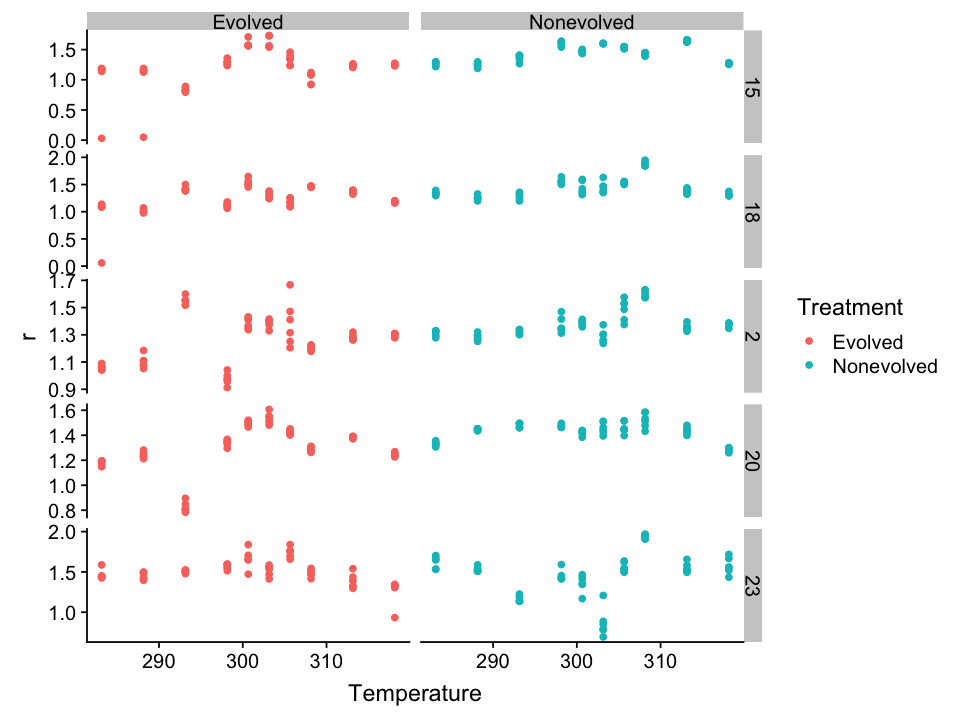

In [189]:
#get species growth from cytometry
OTU_Cyt <- Cyt_all %>%
    filter(Level == "Species", Id != 9) %>%
    mutate(r = (log(AbuT1) - log(AbuT0)) / AT,
           Temperature = Temperature + 273.15,
           Treatment = ifelse(Treatment == "Denovo","Nonevolved",Treatment)) %>%
    select(Id,Treatment,Media,Temperature,Replicate,u,r) %>%
    rename(OTU = Id)

#get min growth rate and shift growth 
min_r <- min(OTU_Cyt$r)
# min_r <- 0 #not min
OTU_Cyt <- OTU_Cyt %>%
    mutate(r = r - min_r) %>%
    filter(r > 0)

options(repr.plot.width = 8, repr.plot.height = 6)

OTU_Cyt %>%
    ggplot(aes(x=Temperature, y = r, colour = Treatment))+
        geom_point()+
        facet_grid(OTU~Treatment, scales = "free")

As we can see the growth rate measures are messy at best. Though we may not be able to fit ss-models we can try taking the rising portion of the TPCs and fitting a simple boltzmann curve.

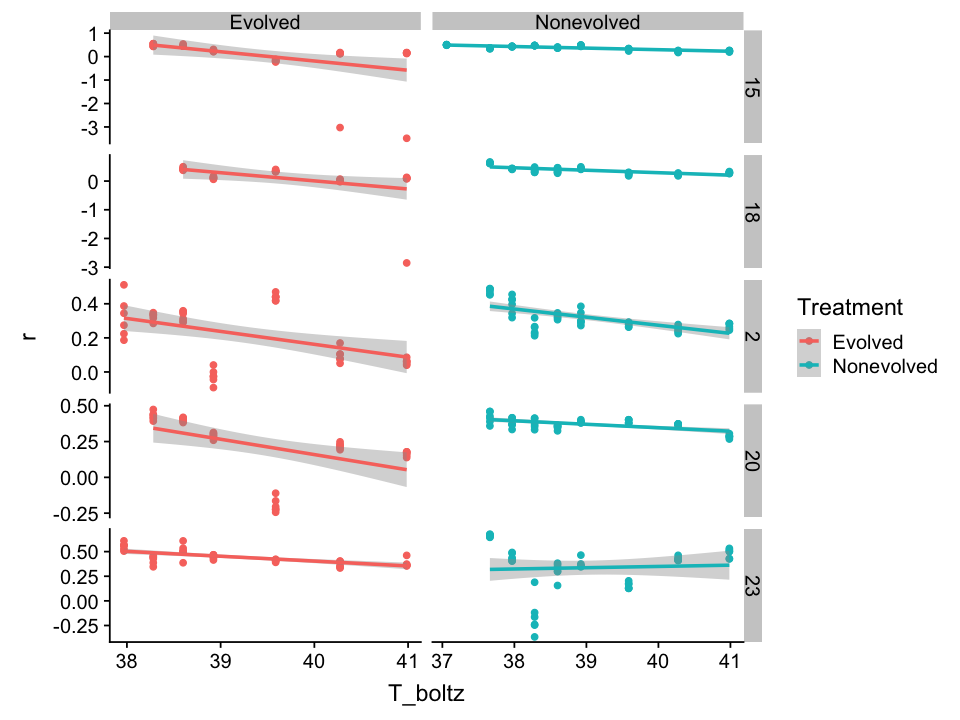

In [190]:
options(repr.plot.width = 8, repr.plot.height = 6)

k <- 8.617e-5
OTU_Cyt_rising <- OTU_Cyt %>%
    group_by(OTU,Treatment,Media) %>%
    mutate(rmax = max(r),Tmax = max(ifelse(r == rmax,Temperature,0))) %>%
    filter(Temperature <= Tmax) %>%
    mutate(T_boltz = 1 / (Temperature * k), r = log(r))

OTU_Cyt_rising %>%
    ggplot(aes(x=T_boltz, y = r, colour = Treatment))+
    geom_point()+
    geom_smooth(method = "lm")+
    facet_grid(OTU ~ Treatment, scale = "free")



In [191]:
OTU_Cyt_r_param <- OTU_Cyt_rising %>%
    select(OTU,Treatment,Media,r,T_boltz) %>%
    group_by(OTU,Treatment,Media) %>%
    do(fit = lm(r ~ T_boltz, data = .)) %>%
    tidy(fit)

OTU_Cyt_r_param

OTU,Treatment,Media,term,estimate,std.error,statistic,p.value
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
15,Evolved,M9,(Intercept),15.60438314,5.276038808,2.9575945,5.606062e-03
15,Evolved,M9,T_boltz,-0.39480236,0.133729032,-2.9522561,5.683495e-03
15,Nonevolved,M9,(Intercept),2.98601289,0.262907084,11.3576738,1.068703e-15
15,Nonevolved,M9,T_boltz,-0.06728489,0.006770064,-9.9385896,1.285387e-13
18,Evolved,M9,(Intercept),11.37018210,4.547357705,2.5003932,1.877741e-02
18,Evolved,M9,T_boltz,-0.28407306,0.114650112,-2.4777391,1.977074e-02
18,Nonevolved,M9,(Intercept),3.72318251,0.463313005,8.0359983,2.617449e-10
18,Nonevolved,M9,T_boltz,-0.08578425,0.011864620,-7.2302570,4.118207e-09
2,Evolved,M9,(Intercept),3.19555711,0.906488250,3.5252052,1.076943e-03


These fits seem to be alright, though not perfect. I'll carry on using them for now but it would be good if we could find some way to get more reliable fits.

In [192]:
OTU_Cyt_r_param <- OTU_Cyt_rising %>%
    select(OTU,Treatment,Media,r,T_boltz) %>%
    group_by(OTU,Treatment,Media) %>%
    do(fit = lm(r ~ T_boltz, data = .)) %>%
    tidy(fit) %>%
    select(OTU,Treatment,Media,term,estimate) %>%
    ungroup() %>%
    nest(-OTU,-Treatment,-term,-Media) %>%
    spread(term,data) %>%
    mutate(r0 = exp(unlist(`(Intercept)`)),
           E = unlist(T_boltz))%>%
    mutate(r0_norm = r0 / exp(-E / (k*293.15)) ) %>%
    select(-`(Intercept)`,-T_boltz,-r0)

OTU_Cyt_r_param$r_min <- min_r
OTU_Cyt_r_param

OTU,Treatment,Media,E,r0_norm,r_min
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
15,Evolved,M9,-0.39480236,0.9755941,-1.276211
15,Nonevolved,M9,-0.06728489,1.3804332,-1.276211
18,Evolved,M9,-0.28407306,1.1326330,-1.276211
18,Nonevolved,M9,-0.08578425,1.3871207,-1.276211
2,Evolved,M9,-0.07583578,1.2134118,-1.276211
2,Nonevolved,M9,-0.04763592,1.3412957,-1.276211
20,Evolved,M9,-0.10714454,1.2254029,-1.276211
20,Nonevolved,M9,-0.02423187,1.4283338,-1.276211
23,Evolved,M9,-0.04928256,1.5282744,-1.276211


So we now have the TPCs for growth for each species. 

## Interactions

Next we want to determine what the interaction parameters are. As we have only measurements of total abundance we must assume symmetrical interactions for now. To do this we first get the total growth rate of each pairwise combination and fit a TPC.

In [193]:
#read in data
pairs_growth_data <- Cyt_all %>%
    filter(Level == "Pairs") %>%
    mutate(r = (log(AbuT1)-log(AbuT0))/AT,
          Treatment = recode(Treatment, "Denovo" = "Nonevolved"),
          Temperature = Temperature + 273.15) %>%
    separate(Id,c("OTU_1","OTU_2"),sep = "-") %>%
    mutate(OTU_1 = ifelse(OTU_1 == "Feb",2,OTU_1))

r_p_min <- min(pairs_growth_data$r)
# r_p_min <- 0 #notmin

pairs_growth_data$r <- pairs_growth_data$r - r_p_min 

pairs_growth_rising <- pairs_growth_data %>%
    filter(r > 0) %>%
    group_by(OTU_1,OTU_2,Treatment,Media) %>%
    mutate(rmax = max(r),Tmax = max(ifelse(r == rmax,Temperature,0))) %>%
    filter(Temperature <= Tmax, r > 0) %>%
    mutate(T_boltz = 1 / (Temperature * k), r = log(r)) %>%
    group_by(OTU_1,OTU_2,Treatment) %>%
    do(fit = lm(r ~ T_boltz, data = .)) %>%
    tidy(fit) %>%
    select(OTU_1,OTU_2,Treatment,term,estimate) %>%
    ungroup() %>%
    nest(-OTU_1,-OTU_2,-Treatment,-term) %>%
    spread(term,data) %>%
    mutate(r0 = exp(unlist(`(Intercept)`)),
           E = unlist(T_boltz))%>%
    mutate(r0_norm = r0 / exp(-E / (k*293.15)) ) %>%
    select(-`(Intercept)`,-T_boltz,-r0)
    

    

In [194]:
r0_ind <- OTU_Cyt_r_param$r0_norm
names(r0_ind) <- paste(OTU_Cyt_r_param$OTU,OTU_Cyt_r_param$Treatment)

E_ind <- OTU_Cyt_r_param$E
names(E_ind) <- paste(OTU_Cyt_r_param$OTU,OTU_Cyt_r_param$Treatment)

pairs_params <- pairs_growth_data %>%
group_by(OTU_1,OTU_2,Treatment) %>%
    summarise(N0 = mean(AbuT0)) %>%
    left_join(pairs_growth_rising,.) %>%
    mutate(r0_1 = recode(paste(OTU_1,Treatment),!!!r0_ind),
           E_1 = recode(paste(OTU_1,Treatment),!!!E_ind),
           r0_2 = recode(paste(OTU_2,Treatment),!!!r0_ind),
           E_2 = recode(paste(OTU_2,Treatment),!!!E_ind))

#ADD N0 TO PAIRS DF
pairs_growth_rising <- pairs_params %>% select(OTU_1,OTU_2,Treatment,N0) %>%
    full_join(pairs_growth_rising)

pairs_params

Joining, by = c("OTU_1", "OTU_2", "Treatment")
Joining, by = c("OTU_1", "OTU_2", "Treatment")


OTU_1,OTU_2,Treatment,E,r0_norm,N0,r0_1,E_1,r0_2,E_2
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
15,18,Evolved,-0.12538531,0.6500515,8098000,0.9755941,-0.39480236,1.1326330,-0.28407306
15,18,Nonevolved,-0.13699137,0.4908621,4477100,1.3804332,-0.06728489,1.3871207,-0.08578425
15,20,Evolved,-0.07033407,0.6389496,11750000,0.9755941,-0.39480236,1.2254029,-0.10714454
15,20,Nonevolved,-0.24831542,0.3921348,11067100,1.3804332,-0.06728489,1.4283338,-0.02423187
15,23,Evolved,-0.07589188,0.7237921,6625000,0.9755941,-0.39480236,1.5282744,-0.04928256
15,23,Nonevolved,-0.19802660,0.4705509,3563620,1.3804332,-0.06728489,1.4108362,0.01288490
18,20,Evolved,-0.11664407,0.6087722,6527000,1.1326330,-0.28407306,1.2254029,-0.10714454
18,20,Nonevolved,-0.23435736,0.4465918,6830900,1.3871207,-0.08578425,1.4283338,-0.02423187
18,23,Evolved,-0.24189781,0.7251684,3930000,1.1326330,-0.28407306,1.5282744,-0.04928256


Then, using the formula described above:

$$
a = \frac{2 r_{pair} - r_i - r_j }{C_{pair}}
$$

we can get the temperature dependence of interactions:

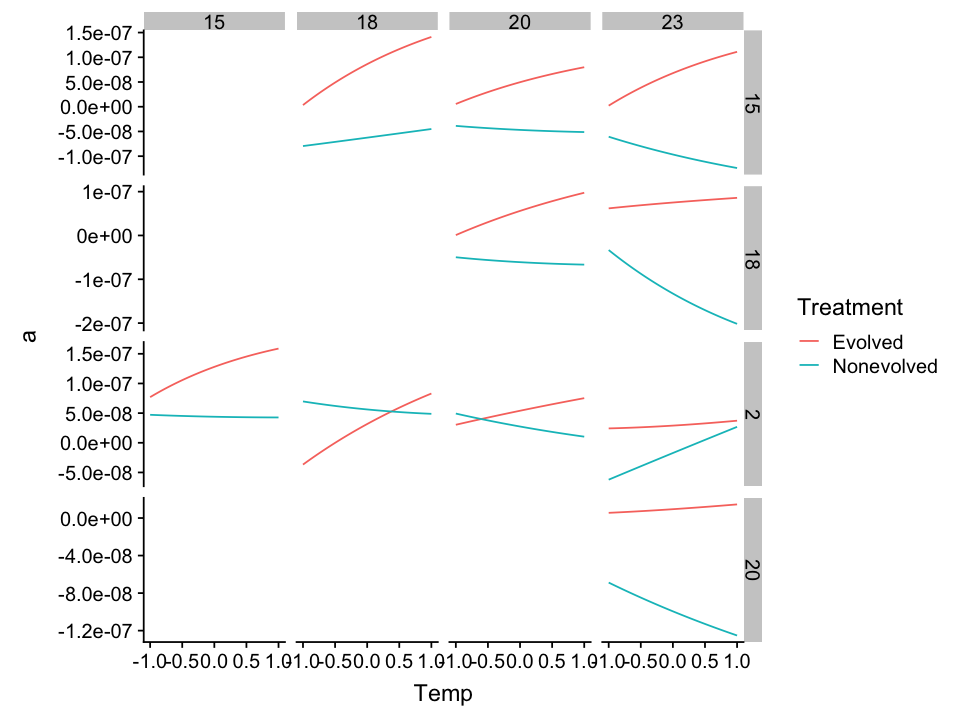

In [195]:
#predicting interactions ect. 
data <- list()

for(i in 1:nrow(pairs_params)){
    df <- data.frame(Temp = seq(-1,1 ,length.out = 100))
    
    df$OTU_1 <- pairs_params$OTU_1[i]
    df$OTU_2 <- pairs_params$OTU_2[i]
    df$Treatment <- pairs_params$Treatment[i]
    
    df$r1 <- pairs_params$r0_1[i] * exp(pairs_params$E_1[i] * df$Temp) + min_r
    df$r2 <- pairs_params$r0_2[i] * exp(pairs_params$E_2[i] * df$Temp) + min_r
    df$r_tot <- pairs_params$r0_norm[i] * exp(pairs_params$E[i] * df$Temp) + r_p_min
    df$N_tot <- pairs_params$N0[i]
    
    df$a <- (2*df$r_tot - df$r1 - df$r2 ) / df$N_tot
    
    data[[i]] <- df
}

interactions_params <- bind_rows(data)

interactions_params %>%
ggplot(aes(x=Temp,group = Treatment, colour = Treatment))+
        geom_line(aes(x=Temp,y=a))+
        facet_grid(OTU_1~OTU_2, scales = "free")

Looks interesting, we can see that some interactions cross from faciliative to competitve as temperature changes. Also there appears to be a difference in the interaction TPCs between the evoloved and non-evolved treatments!

## Simulation Parameters

Finally we want to get some simulation parameters such as how long each simulation should be done for and what the initial biomasses should be. 

In [196]:
#Community parameters
Com_params <- Cyt_all %>%
    filter(Level == "Com") %>%
    mutate(Treatment = recode(Treatment, "Denovo"="Nonevolved"),
           K = Temperature + 273.15) %>%
    select(Replicate,Media,Treatment,K, N0 = AbuT0, N1 = AbuT1, t = AT) %>%
    left_join(Com_R)

head(Com_params)

Joining, by = c("Replicate", "Media", "Treatment", "K")


Replicate,Media,Treatment,K,N0,N1,t,Resp
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,M9,Nonevolved,283.15,10200000,6910000,5,0.4388890
2,M9,Nonevolved,283.15,2380000,6440000,5,0.3971135
3,M9,Nonevolved,283.15,10200000,6910000,5,0.4752216
4,M9,Nonevolved,283.15,2380000,6550000,5,0.3499874
5,M9,Nonevolved,283.15,10200000,5920000,5,0.3583118
6,M9,Nonevolved,283.15,2380000,6650000,5,0.3274234


## Exporting data

We then export all of this data to be used for numerical simualations (in `julia` in a separate document).

In [197]:
#predicting fits
newdata <- tibble(Temp = 293.15)

OTU_R_pred <- gather(OTU_R_fits, 'model', 'output', ncol(OTU_R_fits)) %>%
  unnest(., output %>% map(augment, newdata = newdata))

R_params <- OTU_R_pred %>%
    select(OTU,Treatment,R0 = `.fitted`) %>%
    left_join(OTU_R_E %>% select(OTU,Treatment,e)) %>%
    rename(E = e) %>%
    mutate(E = -E, Treatment = str_replace(Treatment,regex("^evo"),"Evo"))


Joining, by = c("OTU", "Treatment")


In [198]:
pairs_growth_rising %>%
    mutate(r_p_min = r_p_min) %>%
    write_csv("../data/Francisca/Processed/pairs_params.csv")

R_params %>%
    write_csv("../data/Francisca/Processed/R_params.csv")

OTU_Cyt_r_param %>%
    mutate(r_min=min_r) %>%
    write_csv("../data/Francisca/Processed/u_params.csv")

Com_params %>%
    filter(!is.na(Resp)) %>%
    write_csv("../data/Francisca/Processed/Com_params.csv")

# Verification

Now the parameters derived above have been used to simulate community dynamics (see Data_predictions notebook) using the system of equations described above:

$$
\frac{dC_i}{dt} = C_i (r_i + \sum_{i \neq j}^N a_{ij} C_j)
$$

and derive an estimate of communtiy respiration $R_{tot}$ given by:

$$
R_{tot} = \sum^N_i C_i(t) R_i
$$

We can then test these predictions to see how well they fit the empirical data. First we will have a look at the empirical respiration data from the communtiy experiments:

In [199]:
#read in data
Com_R <- read_csv("../data/Francisca/respirationandODData/RespirationRawData_Com.csv", col_types = cols(
  Com = col_character(),
  T = col_double(),
  Replicate = col_double(),
  Resp = col_double()
)) %>%
    separate(Com,c("Treatment","Media")) %>%
    mutate(K = T + 273.15,
           Treatment = recode(Treatment,"Cn" = "Nonevolved","Ce" = "Evolved"),
           Resp = -Resp) %>%
    select(-T) %>%
    filter(Resp > 0)

In [200]:
Com_R_fits <- Com_R %>%
    ungroup() %>%
    nest(-Treatment,-Media) %>%
    mutate(., ss = map(data, ~nls_multstart(Resp ~ sharpeschoolhigh_1981(temp_k = K, r_tref, e, eh, th, tref = 20),
                       data = .x,
                       iter = 500,
                       start_lower = get_start_vals(.x$K, .x$Resp, model_name = 'sharpeschoolhigh_1981') - 10,
                       start_upper = get_start_vals(.x$K, .x$Resp, model_name = 'sharpeschoolhigh_1981') + 10,
                       supp_errors = 'Y')))
    
#predicting fits
newdata <- tibble(K = seq(min(Com_R$K), max(Com_R$K), length.out = 100))

Com_R_pred <- gather(Com_R_fits, 'model', 'output', ncol(Com_R_fits)) %>%
          unnest(., output %>% map(augment, newdata = newdata))

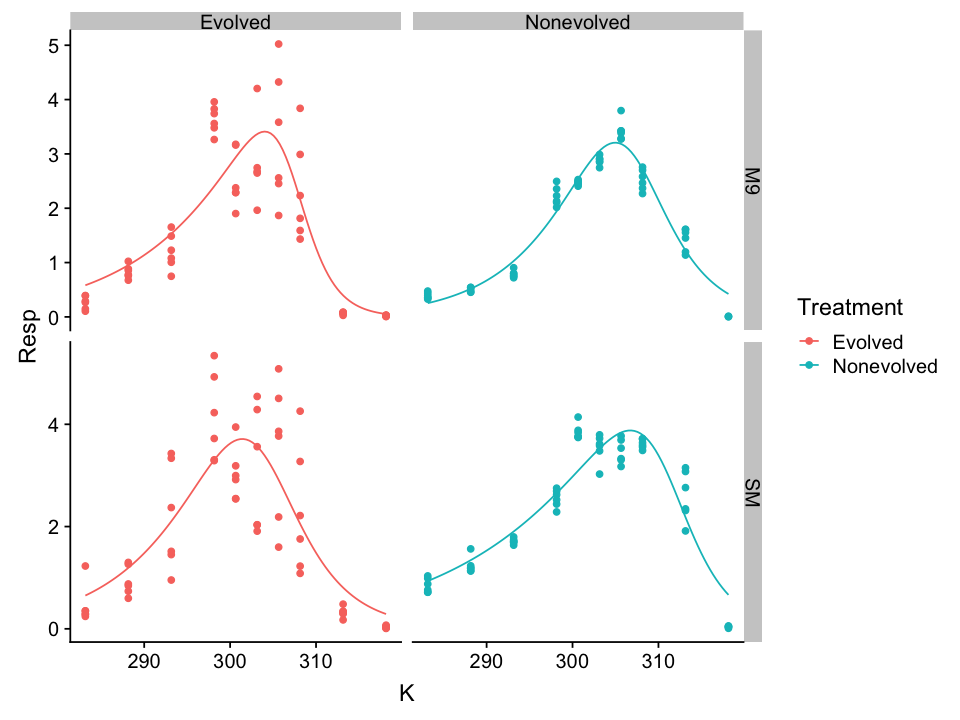

In [201]:
options(repr.plot.width = 8, repr.plot.height = 6)

Com_R %>%
    ggplot(aes(x=K,y = Resp,colour=Treatment))+
    geom_point()+
    facet_grid(Media~Treatment, scale = "free") + 
    geom_line(data = Com_R_pred , aes(y =`.fitted`))

Looks a little noisy but has a clear unimodality in the TPC. Due to the problems with the growth rate data we cant really look past the peak of respiration though we can look at the rising portion. To do this we can take the predicted respiration and get the difference between the observed respiration over temperature:

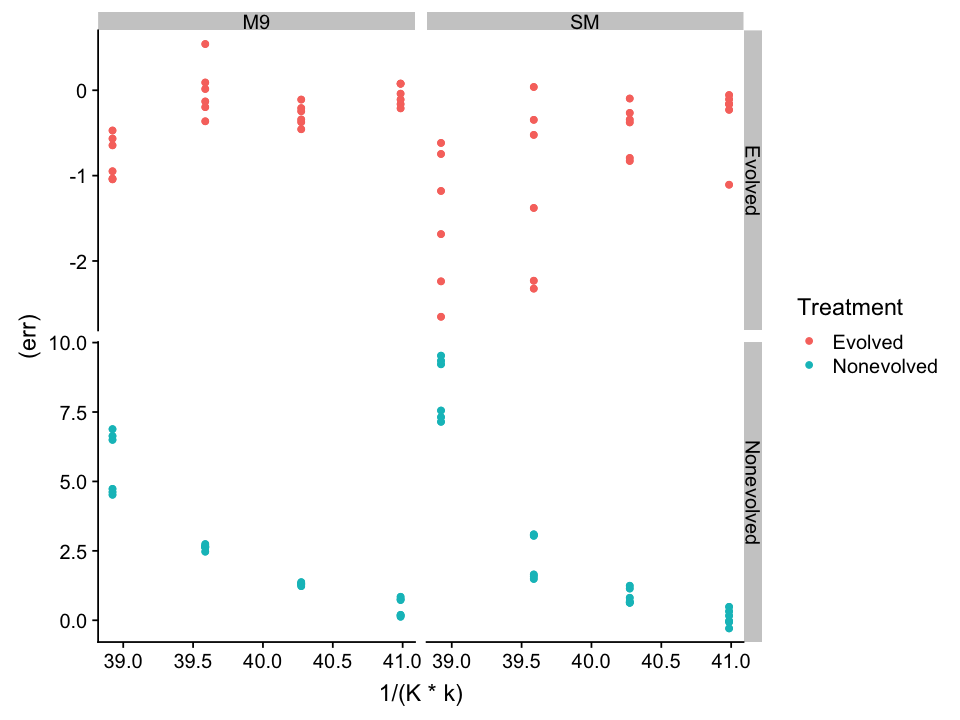

In [202]:
Com_sim_data = read_csv("../data/Simulations/Community_resp.csv", col_types = cols(
  Replicate = col_double(),
  Media = col_character(),
  Treatment = col_character(),
  K = col_double(),
  N0 = col_double(),
  N1 = col_double(),
    
  t = col_double(),
  Resp = col_double(),
  Pred_Resp = col_double()
))

Com_sim_data %>%
    filter(K < 300) %>%
    mutate(err = Pred_Resp - Resp) %>%
    ggplot(aes(x = 1 / (K*k), y = (err), colour = Treatment))+
        geom_point()+
        facet_grid(Treatment~Media, scales = "free")

Some interesting results, We seem to be fairly close in terms of the magnitude of respiration predicted but the errror associated with out prediction has a clear temperature dependence. Furthermore, this temperature dependence in the observed error looks pretty much like a boltzmann curve, increasing for the non-evolved and decreasing for the evolved treatments.

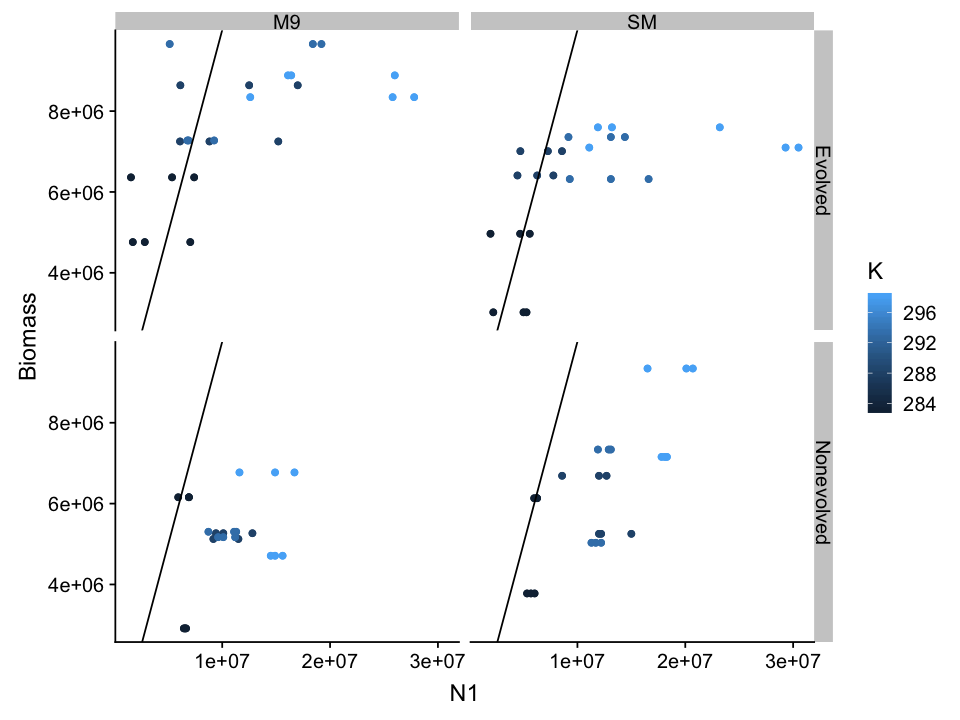

In [215]:
Com_sim_data %>%
    filter(K < 300) %>%
    ggplot(aes(x=N1 ,y=Biomass, colour = K)) +
     geom_point()+
     geom_abline()+
     facet_grid(Treatment ~ Media)

Another way to visualise this shows the same patterns as abundnance (on the y axis) deviates from the observations (on the x) as temperature increases.

In [216]:
Com_sim_data %>%
    filter(K < 300) %>%
    mutate(obs_R_ab = Resp / N1,
           pre)

Replicate,Media,Treatment,K,N0,N1,t,Resp,Pred_Resp,Pred_Resp_Bio,Biomass
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,M9,Nonevolved,283.15,10200000,6910000,5,0.4388890,1.2045734,1.20646763,6157225
2,M9,Nonevolved,283.15,2380000,6440000,5,0.3971135,0.5239432,1.12440688,2912771
3,M9,Nonevolved,283.15,10200000,6910000,5,0.4752216,1.2045734,1.20646763,6157225
4,M9,Nonevolved,283.15,2380000,6550000,5,0.3499874,0.5239432,1.14361258,2912771
5,M9,Nonevolved,283.15,10200000,5920000,5,0.3583118,1.2045734,1.03361626,6157225
6,M9,Nonevolved,283.15,2380000,6650000,5,0.3274234,0.5239432,1.16107232,2912771
1,M9,Nonevolved,283.15,10200000,6910000,5,0.4388890,1.2045734,1.20646763,6157225
2,M9,Nonevolved,283.15,2380000,6440000,5,0.3971135,0.5239432,1.12440688,2912771
3,M9,Nonevolved,283.15,10200000,6910000,5,0.4752216,1.2045734,1.20646763,6157225
